In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.core.debugger import Pdb
from IPython.display import display, clear_output

from QNetwork import neuralnetwork_regression as nn
from GameEngine import multiplayer
from QTable import qtsnake

Point = namedtuple('Point', 'x, y')

pygame 2.5.1 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


### New Game Implementation

I have an improved game implementation which allows for multiplayer snake games, as well as simplified training. This notebook will go over training of a simple q-network, which maps a total of 32 different combinations of states and actions onto rewards, much like the previous q-table implementation from ***revised_snake_q_table.ipynb***.

Please read that notebook first if interested in a more complete description of the new game engine. As usual, we have some game-setup to do:

In [2]:
# defines game window size and block size, in pixels
WINDOW_WIDTH = 640
WINDOW_HEIGHT = 480
GAME_UNITS = 80

In [3]:
game_engine = multiplayer.Playfield(window_width=WINDOW_WIDTH,
                                    window_height=WINDOW_HEIGHT,
                                    units=GAME_UNITS,
                                    g_speed=35,
                                    s_size=1)

In [4]:
p1 = game_engine.add_player()
game_engine.start_game()
p1

Game starting with 1 players.


0

Training thousands of steps is a little bit slow with the graphics on. It makes only a small difference here, but it provides little information anyways:

In [5]:
game_engine.toggle_draw()

Draw is now False.


### State-sensing methods, defining reinforcement and greedy-action selector

I have also imported the aforementioned q_table implementation as qtsnake. It will come back in the end of the notebook when I pair the q_table and q_network against each other, but to make the game fair, I'll use the exact same state-sensing method:

In [6]:
qtsnake.sense_goal

<function QTable.qtsnake.sense_goal(head, goal)>

Even though I plan to only call it when selecting a greedy_action, I'll wrap it in a neat 'query_state' function:

In [7]:
def query_state(id):
    '''
    given a player's id,
    returns their state
    '''
    heads, _, goal = game_engine.get_heads_tails_and_goal()
    return np.array(qtsnake.sense_goal(heads[id], goal))

And a reinforcement function. Because I took the requirement to sense danger away, we only need two outputs from the reinforcement function.

The output of this function was chosen due to being the best-performing. It is possible the reward for GOAL should be higher or lower. In actuality, the reinforcement for non-goals will never be used. I prefer the simplicity of using the discount factor to force agents to the goal quickly.

In [8]:
def reinforcement(outcome):
    '''
    given an outcome of an action,
    returns associated reward
    '''
    if outcome == multiplayer.CollisionType.GOAL:
        return -3
    return 0

Here is the first real interesting function. It takes its implementation largely from the marble example, but it accepts and returns parameters as closely to the previous q-table version.

In essence, I ask the game the viable actions for a player, take into account our current state, and choose the action with the greatest expected reward, or a random action. This is called epsilon greedy selection.

When calling use on the network, it maps a state and action onto a reward, just the same as indexing the q-table. We return the expected reward for this action in addition, because it is needed later for learning with discounted rewards.

In [9]:
def pick_greedy_action(q_net, id, epsilon):
    '''
    given a q network, the id of the player
    taking action, and a randomization factor,
    returns the most rewarding non-lethal action
    or a non-lethal random action and expected reward
    '''
    viable_actions = game_engine.get_viable_actions(id)
    state = query_state(id)

    if viable_actions.size < 1:
        best_action = 0
    elif np.random.uniform() < epsilon:
        best_action = np.random.choice(viable_actions)
    else:
        qs = [q_net.use(np.hstack(
            (state, action)).reshape((1, -1))) for action in viable_actions]
        best_action = viable_actions[np.argmin(qs)]

    X = np.hstack((state, best_action))
    q = q_net.use(X.reshape((1, -1)))

    return X, q

In [10]:
def update_q(q, old_X, new_X, new_q, outcome, n_epochs, discount=0.9, lr=0.2):
    '''
    given a q network, the previous state/action pair,
    the new state/action pair, the expected next reward,
    the outcome of the last action, the number of epochs,
    a discount factor (gamma), and the learning rate
    updates q with discounted rewards.
    '''
    reward = reinforcement(outcome)
    if outcome == multiplayer.CollisionType.GOAL:
        q.train(np.array([new_X]),
                np.array([reward]) + np.array([[reward]]),
                n_epochs, lr, method='sgd', verbose=False)
    else:
        q.train(np.array([old_X]),
                discount * np.array([new_q]), n_epochs,
                lr, method='sgd', verbose=False)

In [12]:
gamma = 0.9
n_epochs = 10
learning_rate = 0.015

hidden_layers = [15]
q = nn.NeuralNetwork(2, hidden_layers, 1)
q.setup_standardization([5, 3.5], [4, np.sqrt(5.25)], [-.1], [0.2])

In [13]:
n_steps = 25000
epsilon = 1
final_epsilon = 0.05
epsilon_decay =  np.exp(np.log(final_epsilon) / (n_steps))
epsilon_trace = np.zeros(n_steps)

In [14]:
class Scoreboard():
    ''' tracks game statistics '''
    def __init__(self):
        self.all_goals = 0
        self._deaths = 0
        self._goals = 0
        self._max_goals = 0

        self.goals = []
        self.deaths = []
        self.max_goals = []

    def track_outcome(self, outcome):
        if outcome == multiplayer.CollisionType.GOAL:
            self._goals += 1
            self.all_goals += 1
            if self._goals > self._max_goals:
                self._max_goals = self._goals
        elif outcome == multiplayer.CollisionType.DEATH:
            self._deaths += 1
            self._goals = 0

    def flush(self):
        self.goals.append(self._goals)
        self.deaths.append(self._deaths)
        self.max_goals.append(self._max_goals)

        self._reset()

    def _reset(self):
        self._deaths = 0
        self._goals = 0
        self._max_goals = 0

In [15]:
def plot_status(q, step, epsilon_trace, r_trace):
    
    plt.subplot(4, 3, 1)
    plt.plot(epsilon_trace[:step + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)

    plt.subplot(4, 3, 2)
    plt.plot(scoreboard.deaths)
    plt.ylabel('Deaths')

    plt.subplot(4, 3, 3)
    plt.plot(scoreboard.goals)
    plt.ylabel('Goals')

    plt.subplot(4, 3, 4)
    plt.plot(scoreboard.max_goals)
    plt.ylabel('Max Score')

    plt.subplot(4, 3, 5)
    plt.plot(r_trace[:step + 1], alpha=0.5)
    binSize = 20
    if step+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(r_trace[:int(step / binSize) * binSize].reshape((int(step / binSize), binSize)), axis=1)
        plt.plot(np.arange(1, 1 + int(step / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')

    plt.subplot(4, 3, 6)
    q.draw(['$o$', '$a$'], ['q'])

    plt.tight_layout()

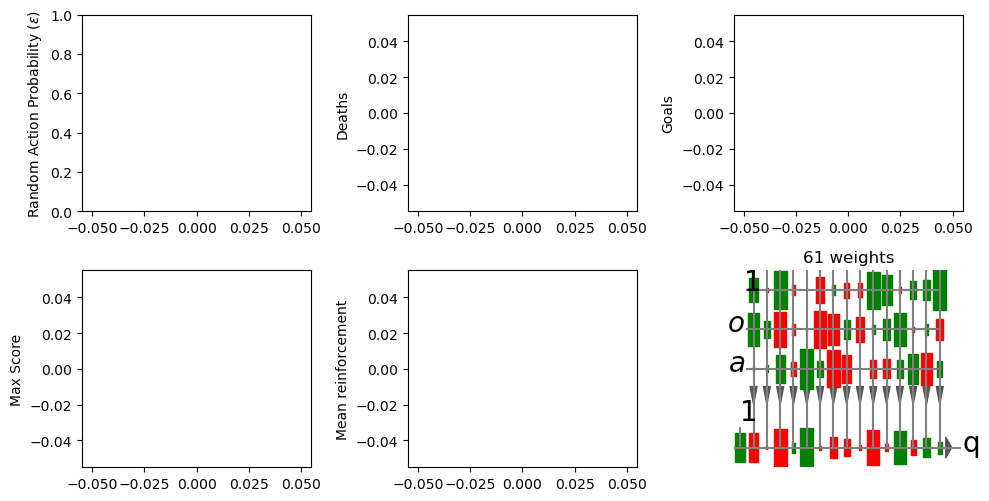

ValueError: cannot reshape array of size 25 into shape (50,20)

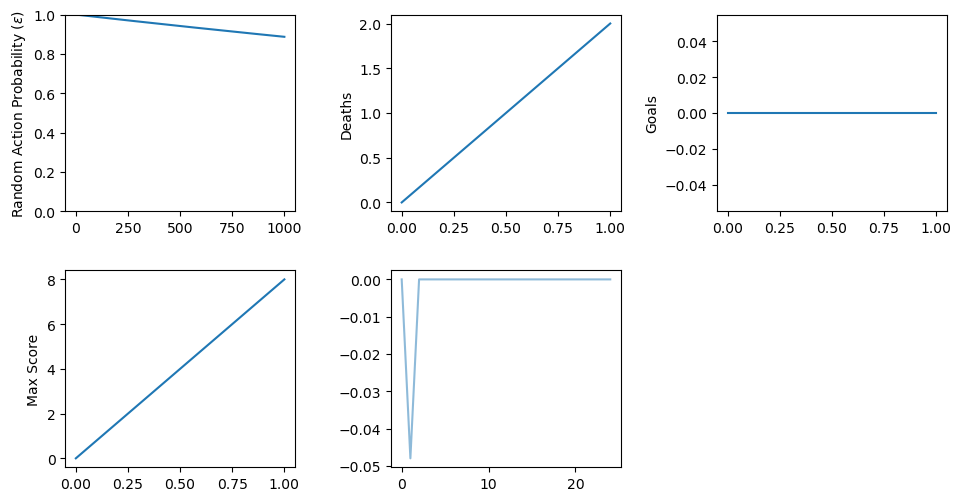

In [16]:
old_X, old_q = pick_greedy_action(q, p1, epsilon)
game_engine.player_advance([old_X[1]])

fig = plt.figure(figsize=(10, 10))
scoreboard = Scoreboard()
plot_spacing = 1000
plotted_steps = 0

R = np.zeros((plot_spacing, 1))
r_trace = np.zeros(n_steps // plot_spacing)

for step in range(n_steps):
    new_X, new_q = pick_greedy_action(q, p1, epsilon)
    outcomes = game_engine.player_advance([new_X[1]])
    scoreboard.track_outcome(outcomes[p1])

    update_q(q, old_X, new_X, new_q, outcomes[p1], n_epochs, lr=learning_rate)

    epsilon *= epsilon_decay
    epsilon_trace[step] = epsilon
    R[step % plot_spacing, 0] = reinforcement(outcomes[p1])
    old_X = new_X
    old_q = new_q

    if step >= plotted_steps:
        r_trace[plotted_steps // plot_spacing] = np.mean(R)
        plotted_steps += plot_spacing
        scoreboard.flush()
        fig.clf()
        plot_status(q, step, epsilon_trace, r_trace)
        scoreboard.all_goals = 0
        clear_output(wait=True)
        display(fig)

In [ ]:
game_engine.toggle_draw()

In [ ]:
epsilon = 0
for step in range(500):
    new_X, _ = pick_greedy_action(q, p1, epsilon)
    game_engine.player_advance([new_X[1]])

In [ ]:
inferior_table = qtsnake.load_q('inferior_qt.npy')
superior_table = qtsnake.load_q('superior_qt.npy')

In [ ]:
epsilon = 0
n_steps = 1500

In [ ]:
game_engine = multiplayer.Playfield(window_width=WINDOW_WIDTH,
                                    window_height=WINDOW_HEIGHT,
                                    units=10,
                                    g_speed=100,
                                    s_size=1)
t1 = game_engine.add_player()
t2 = game_engine.add_player()
n1 = game_engine.add_player()
game_engine.start_game()

In [ ]:
q_table = qtsnake.QSnake(game_engine)

In [ ]:
for step in range(n_steps):
    # table 1
    _, t1_action = q_table.pick_greedy_action(inferior_table, t1, epsilon)

    # table 2
    _, t2_action = q_table.pick_greedy_action(superior_table, t2, epsilon)

    # network 1
    n1_state_action, _ = pick_greedy_action(q, n1, epsilon)
    game_engine.player_advance([t1_action,
                                t2_action,
                                n1_state_action[1]])